## Imports

In [10]:
import numpy as np
from scipy.stats import norm

## Classes definition

In [5]:
class VanillaOption:
    def __init__(self, K, T, option_type):
        self.K = K
        self.T = T
        self.option_type = option_type
        if self.option_type not in ['Call', 'Put']:
            raise ValueError("option_type must be 'Call' or 'Put'")

    def payoff(self, spot):
        if self.option_type == 'Call':
            return max(spot - self.K, 0)
        else:
            return max(self.K - spot, 0)

In [6]:
class BS:
    def __init__(self, S, sigma, r, q):
        self.S = S
        self.sigma = sigma
        self.r = r
        self.q = q

    def mc(self, T, n):
        Z = np.random.randn(n)
        ST = self.S * np.exp((self.r - self.q - 0.5 * self.sigma **2) * T + self.sigma * np.sqrt(T)*Z)
        return ST 

In [4]:
class Heston:
    def __init__(self, S, v0, r, q, kappa, theta, xi, rho):
        self.S = S
        self.v0 = v0
        self.r = r
        self.q = q
        self.kappa = kappa
        self.theta = theta
        self.xi = xi
        self.rho = rho

    def mc(self, T, n, steps):
        dt = T / steps
        S = np.full(n, self.S)
        v = np.full(n, self.v0)

        for _ in range(steps):
            Z1 = np.random.randn(n)
            Z2 = np.random.randn(n)
            dW_v = Z1 * np.sqrt(dt)
            dW_s = (self.rho * Z1 + np.sqrt(1 - self.rho ** 2) * Z2) * np.sqrt(dt)

            v = np.maximum(v + self.kappa * (self.theta - v) * dt + self.xi * np.sqrt(v) * dW_v, 0) 

            S = S * np.exp((self.r - self.q - 0.5 * v) * dt + np.sqrt(v) * dW_s)

        return S 

In [38]:
class SABR:
    def __init__(self, S0, v0, alpha, beta, V, rho, r, q):
        self.S0 = S0
        self.v0 = v0
        self.alpha = alpha
        self.beta = beta
        self.rho = rho
        self.r = r 
        self.q = q 

    def mc(self, T, n, steps):
        S = np.full(n, self.S0)
        sigma = np.full(n, self.v0)
        dt = T / steps
        for _ in range(steps):

            Z1 = np.random.randn(n)
            Z2 = np.random.randn(n)
            dW = Z1 * np.sqrt(dt)
            dZ = (self.rho * Z1 + np.sqrt(1 - self.rho ** 2) * Z2) * np.sqrt(dt)
            sigma = sigma * (1 + self.alpha * np.sqrt(dt) * dZ)
            S = S * np.exp(-0.5 * sigma ** 2 * dt + sigma * np.sqrt(dt) * dW)

        return S 

In [40]:
class Vasicek:
    def __init__(self, a, b, sigma, r0):
        self.a = a
        self.b = b
        self.sigma = sigma
        self.r0 = r0
    
    def mc(self, T, n, steps):
        dt = T / steps
        r = np.full(n, self.r0)

        for _ in range(steps):
            Z = np.random.randn(n)
            dr = self.a * (self.b - r) * dt + self.sigma * np.sqrt(dt) * Z
            r = r + dr

        return r 

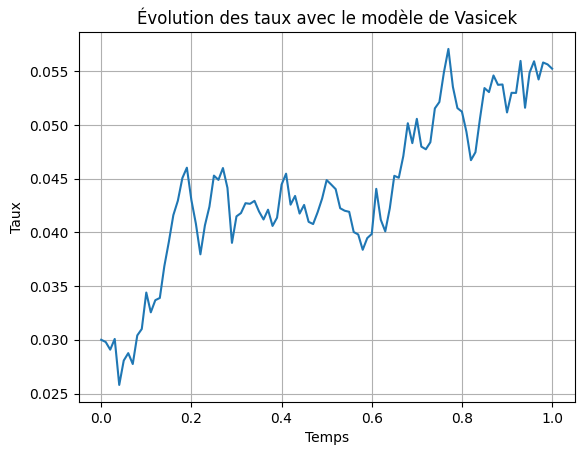

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Paramètres Vasicek
a = 0.1
b = 0.05
r0 = 0.03
sigma = 0.02
T = 1
steps = 100
dt = T / steps

r = np.zeros(steps + 1)
r[0] = r0
for t in range(1, steps + 1):
    Z = np.random.randn()
    dr = a * (b - r[t-1]) * dt + sigma * np.sqrt(dt) * Z
    r[t] = r[t-1] + dr

time = np.linspace(0, T, steps + 1)

plt.plot(time, r)
plt.title("Évolution des taux avec le modèle de Vasicek")
plt.xlabel("Temps")
plt.ylabel("Taux")
plt.grid(True)
plt.show()

## Pricing

In [7]:
class Pricer:
    def __init__(self, model):
        self.model = model

    def price(self, option):
        S = self.model.S
        sigma = self.model.sigma
        r = self.model.r
        q = self.model.q

        K = option.K
        T = option.T
        option_type = option.option_type

        d1 = (np.log(S/K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)

        if option_type == "Call":
            price = S * np.exp(-q * T) * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
        else:
            price = K * np.exp(-r * T) * norm.cdf(-d2) - S * np.exp(-q * T) * norm.cdf(-d1)

        return price

In [8]:
class PricerMC:
    def __init__(self,model):
        self.model = model

    def price(self, option, n, **kwargs):
        T = option.T
        ST = self.model.mc(T, n, **kwargs)
        payoffs = np.array([option.payoff(s) for s in ST])
        price = np.exp(-self.model.r * T) * np.mean(payoffs)
        return price

## Tests

In [11]:
option = VanillaOption(K=100, T=1, option_type='Call')

model = Heston(
    S=130,      
    v0=0.2,      
    r=0.05,      
    q=0,         
    kappa=1.5,
    theta=0.04,
    xi=0.3,
    rho=-0.7
)

pricer = PricerMC(model)

price = pricer.price(option, n=10000, steps=100)

print(f"Prix de l’option via Monte Carlo – Heston : {price:.4f}")



Prix de l’option via Monte Carlo – Heston : 28.7651


In [12]:
bs = BS(S=100, sigma = 0.2, r = 0.05, q=0.01)

option = VanillaOption(K=90, T=1, option_type='Call')

pricer = Pricer(model=bs)

print(f"{option.option_type} price : {pricer.price(option):.4f}")

Call price : 15.8938


In [13]:
option = VanillaOption(K = 90, T = 1, option_type='Call')

model = BS(S = 100, sigma = 0.2, r = 0.05, q = 0.01)

pricer = PricerMC(model)

prix_mc = pricer.price(option, n = 100000)

print(prix_mc)


15.940428911537444


In [17]:
option = VanillaOption(K=100, T = 1, option_type = "Call")
sabr = SABR(S0 = 110, v0 = 0.2, beta = 1, V = 0.4, rho = -0.4, r = 0.03, q = 0, alpha = 0.4)
pricer = PricerMC(sabr)
price = pricer.price(option, n = 10000, steps = 100)
print(price)

7.573536535238365
